Повысить прибыль от допродаж в интернет-магазине на 20%.

***Лог событий(events)***
* timestamp — время события
* visitorid — идентификатор пользователя
* event — тип события
* itemid — идентификатор объекта
* transactionid — идентификатор транзакции, если она проходила

***Дерево категорий(category_tree)***
* category_id — идентификатор категорий
* parent_id — идентификатор родительской категории

***Свойства товаров(item_properties_part1, item_properties_part2)***
* timestamp — момент записи значения свойства
* item_id — идентификатор объекта
* property — свойство, кажется, они все, кроме категории, захешированы
* value — значение свойства

В разделе Валидация есть подгрузка обработанного датасета(нужно только раскомментировать, ссылка:)

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
import plotly.express as px
import seaborn as sns
from scipy.sparse import csr_matrix, coo_matrix
#import implicit
from implicit.cpu.als import AlternatingLeastSquares
import optuna
from optuna.samplers import TPESampler
from sklearn.preprocessing import LabelEncoder
#import lightgbm as lgb
from lightgbm import LGBMRanker
#from collections import defaultdict
import pickle
sns.set_theme('notebook')

In [2]:
#загрузка датасета с событиями
data = pd.read_csv('data/events.csv')
data.head()

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


In [3]:
#загрузка датасета со свойствами товаров
item_properties = pd.concat([pd.read_csv('data/item_properties_part1.csv'), pd.read_csv('data/item_properties_part2.csv')])
properties = item_properties.copy()
properties.head()

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513


In [4]:
#загрузка датасета с иерархией категорий
properties = item_properties.copy()
properties.head()

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513


In [5]:
#загрузка датасета с иерархией категорий
category = pd.read_csv('data/category_tree.csv')
category.head()

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0


# Исследование данных

## events

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 5 columns):
 #   Column         Dtype  
---  ------         -----  
 0   timestamp      int64  
 1   visitorid      int64  
 2   event          object 
 3   itemid         int64  
 4   transactionid  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 105.1+ MB


In [7]:
#поиск полных дубликатов
data.duplicated().sum()

460

In [8]:
#удаление дубликатов
data.drop_duplicates(inplace=True)

In [9]:
#типы событий в датасете
data.event.value_counts()

event
view           2664218
addtocart        68966
transaction      22457
Name: count, dtype: int64

In [10]:
#изменение столбца с датой в формат datetime
data['date']=0
data['date'] = data['timestamp'].apply(lambda x: datetime.fromtimestamp(x/1000).replace(microsecond=0))
data['timestamp'] = data['timestamp'].apply(lambda x: x/1000)

Какой процент продаж обеспечивают топовые товары (точка отсечения — 1 июля)?

In [11]:
#все продажи до 1 июля, сгруппированные по товарам
date_key = datetime.strptime('2015-07-01', '%Y-%m-%d')
data41 = data[data['date']<=date_key].dropna(subset='transactionid').groupby('itemid')['transactionid'].count()

#топ-3 товаров по продажам до 1-го июля
list_top3 = list(data41.sort_values(ascending=False).head(3).index)
list_top3

[119736, 369447, 7943]

In [12]:
date_key = datetime.strptime('2015-07-02', '%Y-%m-%d')
#все продажи после 1-го июля, сгруппированные по товарам
data_top = data[data['date']>=date_key].dropna(subset='transactionid').groupby('itemid')['transactionid'].count()

#доля продаж товаров топ-3(до1-го июля) после 1-го июля
round((data_top[data_top.index.isin(list_top3)].sum())/data_top.sum()*100, 2)

0.61

Товар с идентификатором 369447 очень активно покупался до 1 июля и ни одного раза после(в пределах датасета).

Доля продаж топ-3 товаров меньше 1%.

In [13]:
data.describe()

,timestamp,visitorid,itemid,transactionid,date
count,2.755641e+06,2.755641e+06,2.755641e+06,22457.000000,2755641
mean,1.436424e+09,7.019227e+05,2.349214e+05,8826.497796,2015-07-09 09:46:18.279217664
min,1.430622e+09,0.000000e+00,3.000000e+00,0.000000,2015-05-03 06:00:04
25%,1.433478e+09,3.505660e+05,1.181200e+05,4411.000000,2015-06-05 07:21:34
50%,1.436453e+09,7.020600e+05,2.360620e+05,8813.000000,2015-07-09 17:39:51
75%,1.439225e+09,1.053443e+06,3.507140e+05,13224.000000,2015-08-10 19:44:03
max,1.442545e+09,1.407579e+06,4.668670e+05,17671.000000,2015-09-18 05:59:47
std,3.366334e+06,4.056892e+05,1.341947e+05,5098.996290,NaN


In [14]:
#кодирование целевой переменной
data['target'] = data['event'].apply(lambda x: 0 if x=='view' else 1)

In [15]:
#замена пропусков 0
data['transactionid'] = data['transactionid'].fillna(0)

In [16]:
data.head()

,timestamp,visitorid,event,itemid,transactionid,date,target
0,1.433221e+09,257597,view,355908,0.0,2015-06-02 08:02:12,0
1,1.433224e+09,992329,view,248676,0.0,2015-06-02 08:50:14,0
2,1.433222e+09,111016,view,318965,0.0,2015-06-02 08:13:19,0
3,1.433222e+09,483717,view,253185,0.0,2015-06-02 08:12:35,0
4,1.433221e+09,951259,view,367447,0.0,2015-06-02 08:02:17,0


In [17]:
#создание признаков месяц, день, день недели, выходные, час, минута
data['month'] = data['date'].apply(lambda x: x.month)
data['day'] = data['date'].apply(lambda x: x.day)
data['dayofweek'] = data['date'].apply(lambda x: x.weekday())
data['weekend'] = data['dayofweek'].apply(lambda x: 1 if (x==5)|(x==6) else 0)
data['hour'] = data['date'].apply(lambda x: x.hour)
data['minute'] = data['date'].apply(lambda x: x.minute)

In [18]:
#создание признака время дня
def time_day(hour):
    if 0 <= hour < 6: # ночь
        return 1
    elif 6 <= hour < 12: # утро
        return 2
    elif 12 <= hour < 18: # день
        return 3
    else: # вечер
        return 4
data['timeday'] = data['hour'].apply(time_day)

In [19]:
data.head()

,timestamp,visitorid,event,itemid,transactionid,date,target,month,day,dayofweek,weekend,hour,minute,timeday
0,1.433221e+09,257597,view,355908,0.0,2015-06-02 08:02:12,0,6,2,1,0,8,2,2
1,1.433224e+09,992329,view,248676,0.0,2015-06-02 08:50:14,0,6,2,1,0,8,50,2
2,1.433222e+09,111016,view,318965,0.0,2015-06-02 08:13:19,0,6,2,1,0,8,13,2
3,1.433222e+09,483717,view,253185,0.0,2015-06-02 08:12:35,0,6,2,1,0,8,12,2
4,1.433221e+09,951259,view,367447,0.0,2015-06-02 08:02:17,0,6,2,1,0,8,2,2


In [20]:
# финальная таблица
df = pd.DataFrame()
df = data.drop('transactionid', axis=1)

In [21]:
df.head()

,timestamp,visitorid,event,itemid,date,target,month,day,dayofweek,weekend,hour,minute,timeday
0,1.433221e+09,257597,view,355908,2015-06-02 08:02:12,0,6,2,1,0,8,2,2
1,1.433224e+09,992329,view,248676,2015-06-02 08:50:14,0,6,2,1,0,8,50,2
2,1.433222e+09,111016,view,318965,2015-06-02 08:13:19,0,6,2,1,0,8,13,2
3,1.433222e+09,483717,view,253185,2015-06-02 08:12:35,0,6,2,1,0,8,12,2
4,1.433221e+09,951259,view,367447,2015-06-02 08:02:17,0,6,2,1,0,8,2,2


Данные с 3 мая по 18 сентября 2015 года. Целевая переменная заменена на бинарную(просмотр - 0, добавление в корзину и покупка - 1). Создана новая таблица, которая будет итоговой, со столбцами пользователь, товар, действие и созданные из даты - месяц, число, день недели, будни-выходные, час, минуты, время дня.

## item_properties

In [22]:
properties.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20275902 entries, 0 to 9275902
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   timestamp  int64 
 1   itemid     int64 
 2   property   object
 3   value      object
dtypes: int64(2), object(2)
memory usage: 773.5+ MB


In [23]:
#поиск полных дубликатов
properties.duplicated().sum()

0

In [24]:
#изменение столбца с датой в формат datetime
properties['date']=0
properties['date'] = properties['timestamp'].apply(lambda x: datetime.fromtimestamp(x/1000).replace(microsecond=0))

In [25]:
properties.describe()

,timestamp,itemid,date
count,2.027590e+07,2.027590e+07,20275902
mean,1.435157e+12,2.333904e+05,2015-06-24 17:42:23.682881536
min,1.431227e+12,0.000000e+00,2015-05-10 06:00:00
25%,1.432436e+12,1.165160e+05,2015-05-24 06:00:00
50%,1.433646e+12,2.334830e+05,2015-06-07 06:00:00
75%,1.437880e+12,3.503040e+05,2015-07-26 06:00:00
max,1.442113e+12,4.668660e+05,2015-09-13 06:00:00
std,3.327798e+09,1.348452e+05,NaN


In [26]:
properties.describe(include='object')

,property,value
count,20275902,20275902
unique,1104,1966868
top,888,769062
freq,3000398,1537247


In [27]:
properties.head()

,timestamp,itemid,property,value,date
0,1435460400000,460429,categoryid,1338,2015-06-28 06:00:00
1,1441508400000,206783,888,1116713 960601 n277.200,2015-09-06 06:00:00
2,1439089200000,395014,400,n552.000 639502 n720.000 424566,2015-08-09 06:00:00
3,1431226800000,59481,790,n15360.000,2015-05-10 06:00:00
4,1431831600000,156781,917,828513,2015-05-17 06:00:00


In [28]:
#сортировка по дате, чтобы из всех дубликатов оставались последние добавленные
properties = properties.sort_values('date', ascending=False)

In [29]:
#уникальные пары свойство-товар
properties_noduplicate = properties.drop_duplicates(['property', 'itemid'])

In [30]:
#количество уникальных идентификаторов товаров
properties.itemid.nunique()

417053

In [31]:
#ранжирование свойств по частоте
properties_50 = properties_noduplicate.groupby('property')['itemid'].count().sort_values(ascending=False)

In [32]:
properties_50.head(3)

property
categoryid    417053
159           417053
790           417053
Name: itemid, dtype: int64

In [33]:
list_drop = properties_50[properties_50==properties.itemid.nunique()].index #список свойств, которые есть у всех товаров
properties_50.drop(list_drop, axis=0, inplace=True) #удаление предыдущих свойств
properties_50 = properties_50[:20] #выбор 50-ти самых часто встречающихся свойств

Есть свойства которые встречаются у всех товаров, но они либо имеют 1 значение, либо очень много, из-за этого не получится использовать значения свойств. Попробую использовать таблицу со свойствами для добавления наличия свойства у товара(за исключением свойств, которые есть у всех)

In [34]:
#удаление товаров, для которых нет свойств(никаких, в том числе)
list_drop = list(df[~df.itemid.isin(list(properties.itemid.unique()))].index)
print(f'Процент товаров c отсутствующими свойствами - {round(len(df)/len(list_drop), 2)}%')
df.drop(list_drop, axis=0, inplace=True)

Процент товаров c отсутствующими свойствами - 10.78%


процент небольшой, датасет объемный, думаю лучше всего подойдёт удаление этих товаров

In [35]:
#добавление столбцов со свойствами(1-есть, 0-нет)
for i in properties_50.index:
    temp = pd.DataFrame(properties_noduplicate[properties_noduplicate.property==i]['itemid'], columns=['itemid'])
    temp[f'property_{i}'] = 1
    df = df.merge(temp, on='itemid', how='left').fillna(0)

## Корреляция

In [36]:
#таблица корреляций
df_corr = df.drop('event', axis=1).corr()

Text(0.5, 1.0, 'Тепловая карта корреляции')

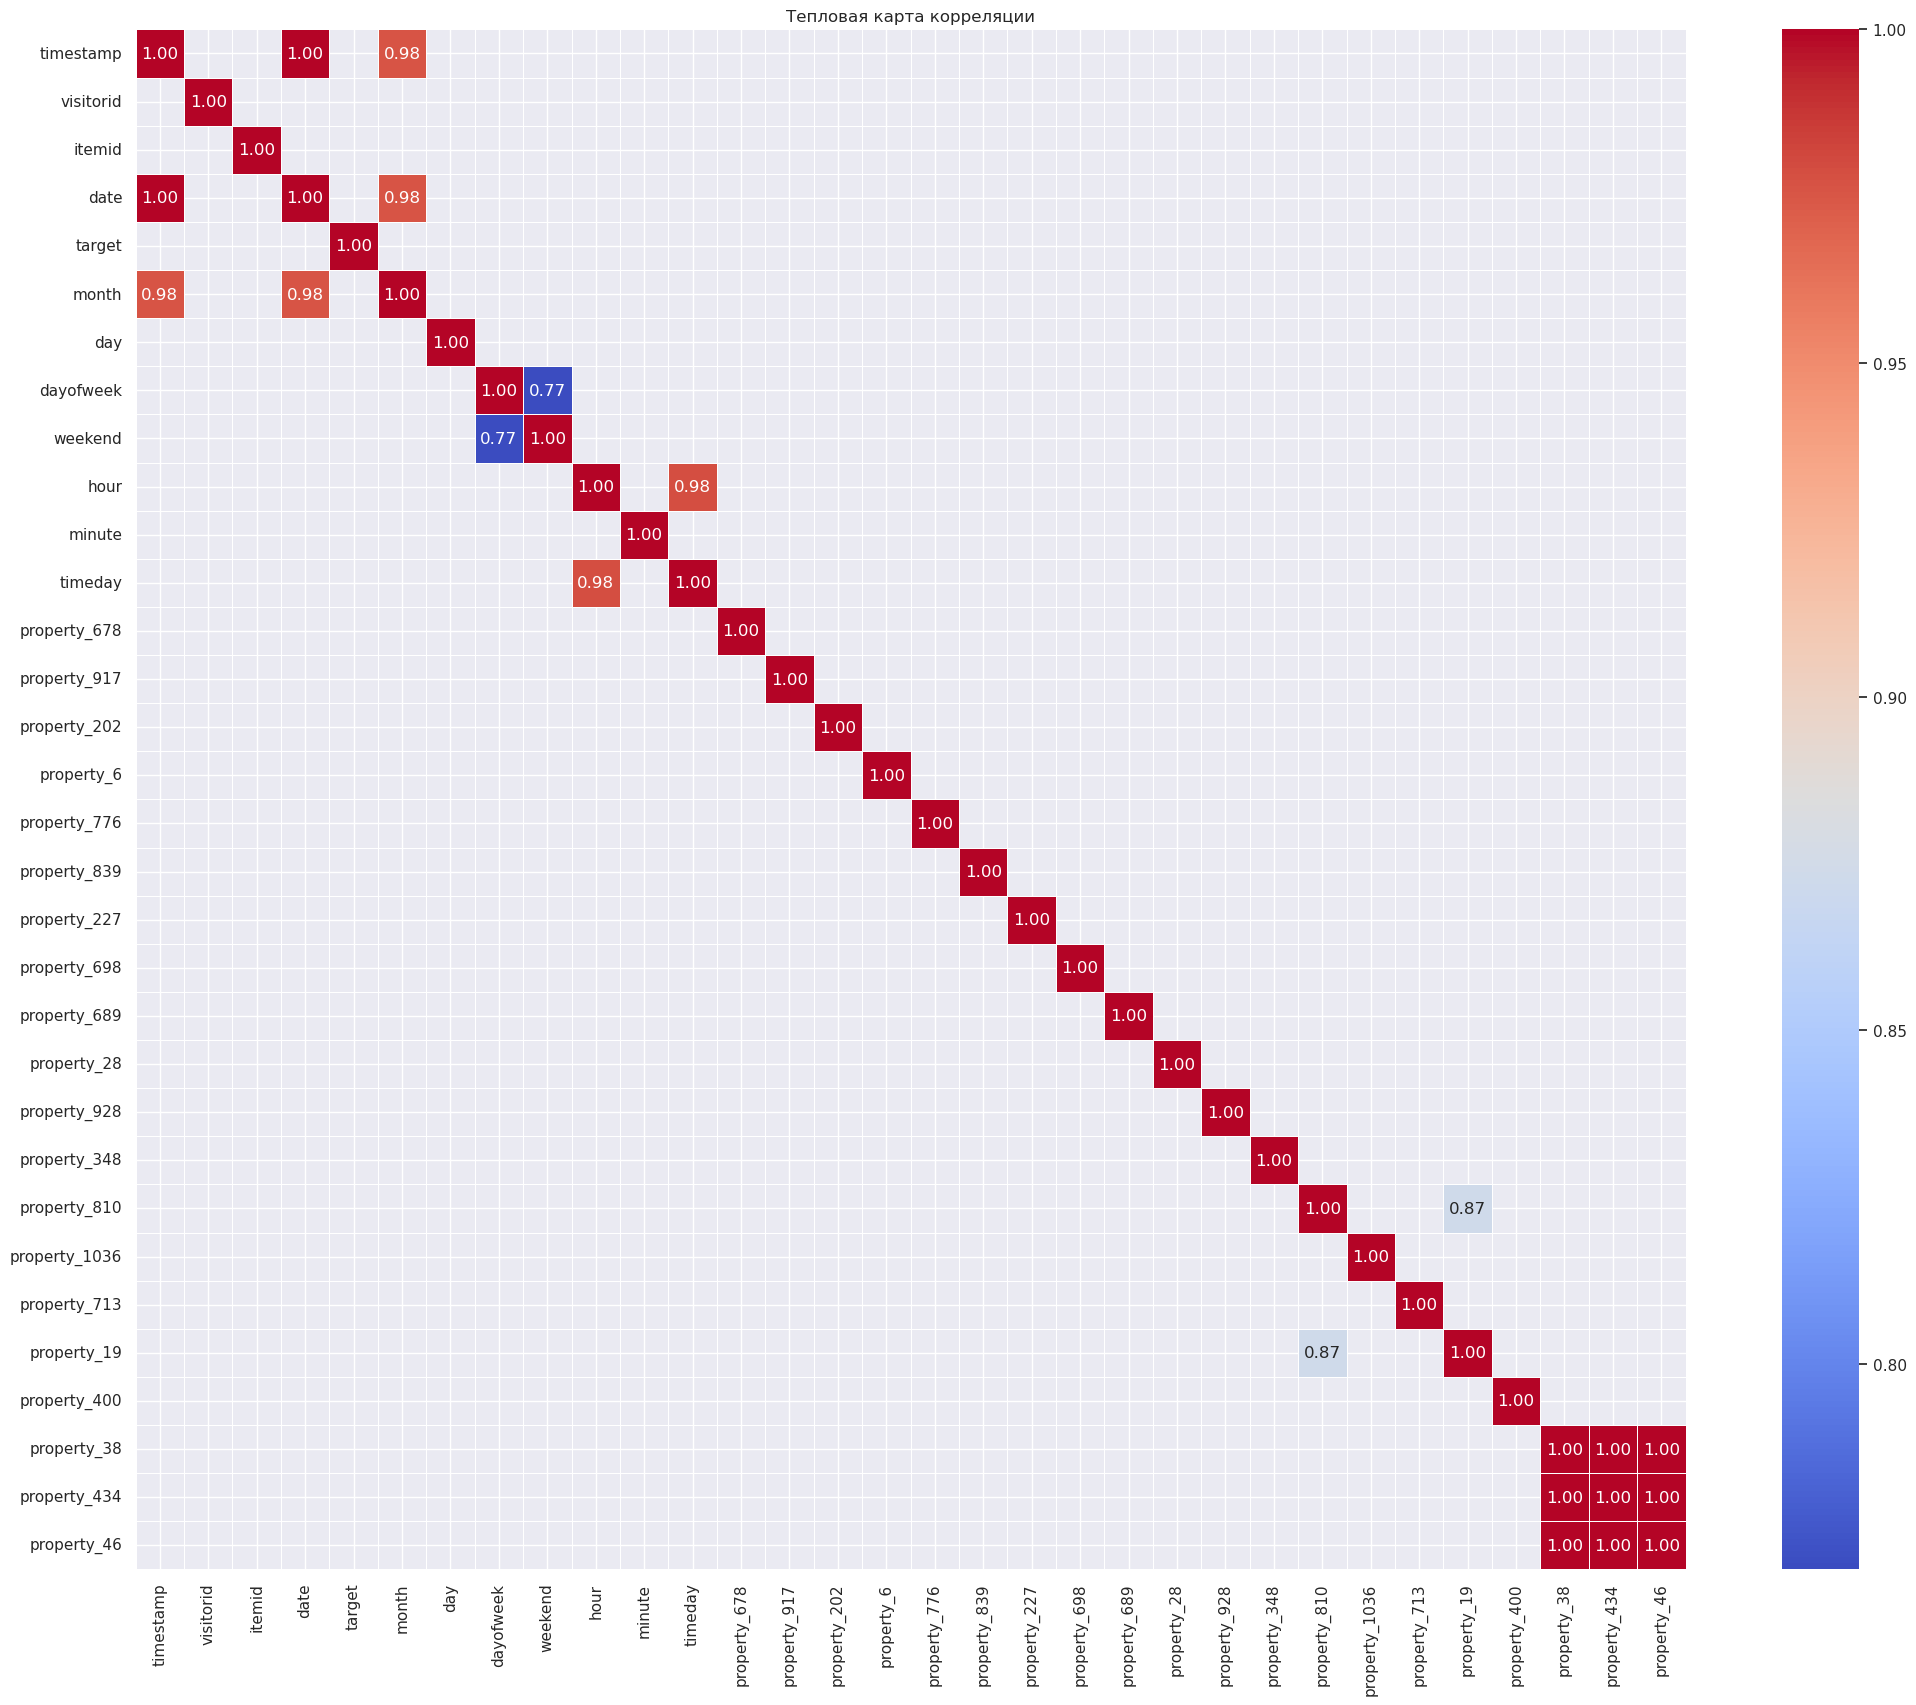

In [37]:
#корреляция между признаками, превышающая значение 0,7
fig = plt.figure(figsize = (25,20))

ax = sns.heatmap(df_corr[0.7<=df_corr.abs()], fmt='.2f', linewidths=.4, cmap='coolwarm', annot=True)

ax.set_title('Тепловая карта корреляции')

In [38]:
#список столбцов в порядке возрастания корреляции c целевой переменной
df_corr_clean = df_corr.copy()
df_corr_clean.target = abs(df_corr_clean.target)
list_corr_sort = pd.DataFrame(df_corr_clean.sort_values('target').index, columns=['name']).reset_index()

In [39]:
#список признаков, которые останутся в очищенном датасете
list_corr_clean = ['visitorid', 'target', 'itemid', 'date', 'event', 'timestamp', 'timeday', 'month', 'dayofweek', 'weekend']

for i in list_corr_sort.name: # имена всех столбцов
    if i in list_corr_clean:
        continue
    else:
        temp = df_corr[abs(df_corr[i])>0.7][i].index # имена столбцов c сильной корреляцией между собой
        temp = pd.DataFrame(temp, columns=['name']) # таблица c именами скоррелированных столбцов
        temp = temp.merge(list_corr_sort, on='name', how='left') # добавление номера в ранжированном списке по корреляции c целевой переменнной
        list_corr_clean.append(temp.sort_values('index', ascending=False).iloc[0, 0]) # сортировка по корреляции c целевой переменной
    
list_corr_clean = list(set(list_corr_clean)) # удаление дубликатов из финального списка столбцов

In [40]:
df = df[list_corr_clean]

In [41]:
df.head()

,visitorid,property_928,itemid,property_28,timeday,month,property_678,property_839,property_698,date,...,property_19,dayofweek,weekend,timestamp,property_776,property_348,property_1036,target,property_202,property_6
0,257597,1.0,355908,0.0,2,6,1.0,1.0,1.0,2015-06-02 08:02:12,...,0.0,1,0,1.433221e+09,1.0,0.0,1.0,0,1.0,1.0
1,992329,0.0,248676,0.0,2,6,1.0,1.0,1.0,2015-06-02 08:50:14,...,0.0,1,0,1.433224e+09,1.0,0.0,1.0,0,1.0,1.0
2,483717,0.0,253185,0.0,2,6,1.0,1.0,1.0,2015-06-02 08:12:35,...,0.0,1,0,1.433222e+09,1.0,0.0,0.0,0,1.0,1.0
3,951259,0.0,367447,0.0,2,6,1.0,1.0,1.0,2015-06-02 08:02:17,...,0.0,1,0,1.433221e+09,1.0,0.0,1.0,0,1.0,1.0
4,972639,0.0,22556,0.0,2,6,1.0,1.0,1.0,2015-06-02 08:48:06,...,1.0,1,0,1.433224e+09,1.0,0.0,0.0,0,1.0,0.0


## category_tree

In [42]:
category.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1669 entries, 0 to 1668
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   categoryid  1669 non-null   int64  
 1   parentid    1644 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 26.2 KB


In [43]:
category.head()

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0


In [44]:
#рекурсивная функция для расчета вложенности категорий
def tree(x, list_parent=[]):
    df_tree = x.copy()
    if df_tree.shape[1] < 3: #первая итерация
        df_tree['nesting'] = 0 #столбец вложенности
        df_parent = df_tree[df_tree.parentid.isna()] #df c категориями начального уровня
        list_parent = list(df_parent['categoryid'].values) #список категорий начального уровня
        #объединение начальной категории c меткой 0 и значений отправленных на дальнейшую обработку
        print(df_tree[~df_tree.parentid.isna()].shape)
        return pd.concat([df_parent, tree(df_tree[~df_tree.parentid.isna()], list_parent)])
    else:
        while not x.empty: #пока не пустой
            df_tree['nesting'] +=1 #прибавление вложенности
            df_parent = df_tree[df_tree['parentid'].isin(list_parent)] #df со значениями у которых родители есть в списке
            list_parent.extend(list(df_parent['categoryid'].values)) #добавление значений чьи родители в списке
            #объединение значений, остающихся на этом уровне, cо значениями у которых родителей нет в списке(после обработки)
            print(df_tree[~df_tree['categoryid'].isin(list_parent)].shape)
            return pd.concat([df_parent, tree(df_tree[~df_tree['categoryid'].isin(list_parent)], list_parent)])

In [45]:
category = tree(category)

(1644, 3)
(1470, 3)
(768, 3)
(103, 3)
(13, 3)
(0, 3)


In [46]:
#распределение вложенности
category.nesting.value_counts()

nesting
2    702
3    665
1    174
4     90
0     25
5     13
Name: count, dtype: int64

In [47]:
category.describe()

,categoryid,parentid,nesting
count,1669.000000,1644.000000,1669.000000
mean,849.285201,847.571168,2.395446
std,490.195116,505.058485,0.832135
min,0.000000,8.000000,0.000000
25%,427.000000,381.000000,2.000000
50%,848.000000,866.000000,2.000000
75%,1273.000000,1291.000000,3.000000
max,1698.000000,1698.000000,5.000000


In [48]:
#таблица связывающая itemid и categoryid
df_category = properties[properties['property']=='categoryid'][['itemid', 'value', 'date']].drop_duplicates()
df_category['categoryid'] = df_category.value.astype('int') #изменение типа
df_category.drop('value', axis=1, inplace=True)
df_category = df_category.merge(category.drop('parentid', axis=1), on='categoryid', how='left')

In [49]:
#сортировка по дате, чтобы из всех дубликатов оставались последние добавленные
df_category = df_category.sort_values('date')
df_category = df_category.drop_duplicates(['itemid'])

In [50]:
#добавление столбца c вложенностью категорий и столбца c категорией
df = df.merge(df_category[['itemid', 'categoryid', 'nesting']], on=['itemid'], how='left')

In [51]:
def target_encode(df, cat_col, target_col, smooth=10):
    '''Функция для кодирования категориальных признаков:
    вычисление средних по категориям + сглаживание'''
    averages = df.groupby(cat_col)[target_col].mean()
    counts = df.groupby(cat_col)[target_col].count()
    global_mean = df[target_col].mean()
    encoded = (averages * counts + global_mean * smooth) / (counts + smooth)
    return df[cat_col].map(encoded)

In [52]:
df['categoryid_enc'] = target_encode(df, 'categoryid', 'target')

# Валидация

### Загрузка

In [ ]:
#изменение ключевой таблицы, если потребуется
#data = df.copy()
#data.to_csv('data/data.csv', index=False)

In [54]:
#загрузка данных
#df = pd.read_csv('data/data.csv')

In [ ]:
#сортировка по дате(по возрастанию)
df = df.sort_values('date')
df_temp = df.groupby('visitorid')['visitorid'].count() #количество действий пользователя
dfmin = df[df.visitorid.isin(df_temp[df_temp>=5].index)] #пользователи, сделавшие минимум 5 действий
temp = df.groupby('visitorid')['target'].sum()
dfmin = dfmin[dfmin.visitorid.isin(temp[temp>0].index)] #пользователи, совершившие хотя бы одну покупку
traindf, testdf = train_test_split(dfmin, test_size=0.3, shuffle=False, random_state=19)

In [56]:
print(traindf.shape)
print(testdf.shape)

(247158, 32)
(105926, 32)


### Признаки для товаров

In [57]:
def value_top(dataframe, column, target):
    '''Функция для выбора топового значения для каждого пользователя или товара:
    	column - топ чего нужен; 
    	target - столбец по которому нужна группировка(товар или пользователь)'''
    temp = dataframe.groupby(target)[column].agg(lambda x: x.value_counts().index[0]).reset_index()
    temp.rename(columns={column:target+'_'+column}, inplace=True)
    return dataframe.merge(temp, on=[target], how='left')
    

In [58]:
traindf = value_top(traindf, 'day', 'itemid')
traindf = value_top(traindf, 'weekend', 'itemid')
traindf = value_top(traindf, 'timeday', 'itemid')
traindf['item_count'] = traindf.groupby('itemid')['target'].transform('count') #количество товара в таблице
traindf['item_purchase_count'] = traindf.groupby('itemid')['target'].transform('sum').fillna(0) #количество покупок товара в таблице
traindf['item_mean'] = traindf.groupby('itemid')['target'].transform('mean') #средняя конверсия по товару
#количество дней с последнего просмотра
traindf['item_days_since_last_view'] = round((testdf.timestamp.min() - traindf.groupby('itemid')['timestamp'].transform('max'))/86400)
#популярность категории товара
traindf['category_popularity'] = traindf.groupby('categoryid')['itemid'].transform('count')
#насколько часто покупают в категории товара
traindf['category_popularity_purchase'] = traindf.groupby('categoryid')['target'].transform('sum')
#средняя конверсия в категории
traindf['category_avg_conversion'] = traindf.groupby('categoryid')['target'].transform('mean')
#количество уникальных товаров в категории
traindf['category_unique_items'] = traindf.groupby('categoryid')['itemid'].transform('nunique')
#количество уникальных пользователей, просмотревших товар
traindf['item_unique_users'] = traindf.groupby('itemid')['visitorid'].transform('nunique')
#доля возвращающихся пользователей
traindf['item_returning_users_ratio'] = traindf.groupby('itemid')['visitorid'].transform(lambda x: x.duplicated().mean())


In [59]:
#количество взаимодействий с товаром за 7 последних дней
items7 = traindf[traindf['timestamp'] > (traindf.timestamp.max() - (86400*7))].groupby('itemid')['target'].count().rename('item_recent_7d')
#количество покупок товара за 7 последних дней
items7_purchase = traindf[traindf['timestamp'] > (traindf.timestamp.max() - (86400*7))].groupby('itemid')['target'].sum().rename('item_recent_7d_purchase')
#количество взаимодействий с товаром за 30 последних дней
items30 = traindf[traindf['timestamp'] > (traindf.timestamp.max() - (86400*30))].groupby('itemid')['target'].count().rename('item_recent_30d')
#количество покупок товара за 30 последних дней
items30_purchase = traindf[traindf['timestamp'] > (traindf.timestamp.max() - (86400*30))].groupby('itemid')['target'].sum().rename('item_recent_30d_purchase')
#количество дней с последней покупки
days_since_last_purchase = round((testdf.timestamp.min() - traindf[traindf.target==1].groupby('itemid')['timestamp'].max())/86400).rename('item_days_since_last_purchase')
#добавление признаков в таблицу
traindf = pd.merge(traindf, items7, on='itemid', how='left')
traindf = pd.merge(traindf, items7_purchase, on='itemid', how='left')
traindf = pd.merge(traindf, items30, on='itemid', how='left')
traindf = pd.merge(traindf, items30_purchase, on='itemid', how='left')
traindf = pd.merge(traindf, days_since_last_purchase, on='itemid', how='left')

In [60]:
#пустые значения, для которых нет данных
traindf.isnull().sum().sort_values(ascending=False)

item_recent_7d_purchase          155522
item_recent_7d                   155522
item_recent_30d_purchase          65089
item_recent_30d                   65089
item_days_since_last_purchase     56434
item_count                            0
property_202                          0
property_6                            0
categoryid                            0
nesting                               0
categoryid_enc                        0
itemid_day                            0
itemid_weekend                        0
itemid_timeday                        0
item_days_since_last_view             0
item_purchase_count                   0
item_mean                             0
property_928                          0
category_popularity                   0
category_popularity_purchase          0
category_avg_conversion               0
category_unique_items                 0
item_unique_users                     0
item_returning_users_ratio            0
target                                0


In [61]:
#все заполняем 0, а дни с последней покупки большим числом
traindf.fillna({'item_recent_7d_purchase': 0,'item_recent_30d_purchase': 0,'item_recent_7d': 0,
                'item_days_since_last_purchase': 120,'item_recent_30d': 0
				}, inplace=True)

In [62]:
traindf.columns

Index(['visitorid', 'property_928', 'itemid', 'property_28', 'timeday',
       'month', 'property_678', 'property_839', 'property_698', 'date',
       'property_689', 'property_434', 'property_917', 'day', 'minute',
       'event', 'property_227', 'property_400', 'property_713', 'property_19',
       'dayofweek', 'weekend', 'timestamp', 'property_776', 'property_348',
       'property_1036', 'target', 'property_202', 'property_6', 'categoryid',
       'nesting', 'categoryid_enc', 'itemid_day', 'itemid_weekend',
       'itemid_timeday', 'item_count', 'item_purchase_count', 'item_mean',
       'item_days_since_last_view', 'category_popularity',
       'category_popularity_purchase', 'category_avg_conversion',
       'category_unique_items', 'item_unique_users',
       'item_returning_users_ratio', 'item_recent_7d',
       'item_recent_7d_purchase', 'item_recent_30d',
       'item_recent_30d_purchase', 'item_days_since_last_purchase'],
      dtype='object')

In [63]:
#столбцы с признаками товаров
item_features = ['property_6', 'property_928', 'property_227', 'property_202',
                 'property_689', 'property_713', 'property_678', 'property_348',
                 'property_839', 'property_917', 'property_1036', 'property_19',
                 'property_28', 'property_776', 'property_434', 'property_698',
                 'property_400', 'categoryid', 'nesting', 'categoryid_enc',
                 'itemid_day', 'itemid_weekend', 'itemid_timeday', 'item_count',
                 'item_purchase_count', 'item_mean', 'item_days_since_last_view', 'category_popularity',
                 'category_avg_conversion', 'category_unique_items', 'item_unique_users', 'item_returning_users_ratio',
                 'item_recent_7d_purchase', 'item_recent_30d_purchase','item_recent_7d', 'category_popularity_purchase',
                 'item_days_since_last_purchase','item_recent_30d'
				]

In [64]:
#важность признаков
mi_scores = mutual_info_classif(traindf[item_features], traindf['target'], random_state=19)
mi_df = pd.DataFrame({'feature': item_features, 'mi_score': mi_scores}).sort_values('mi_score', ascending=False).reset_index(drop=True)

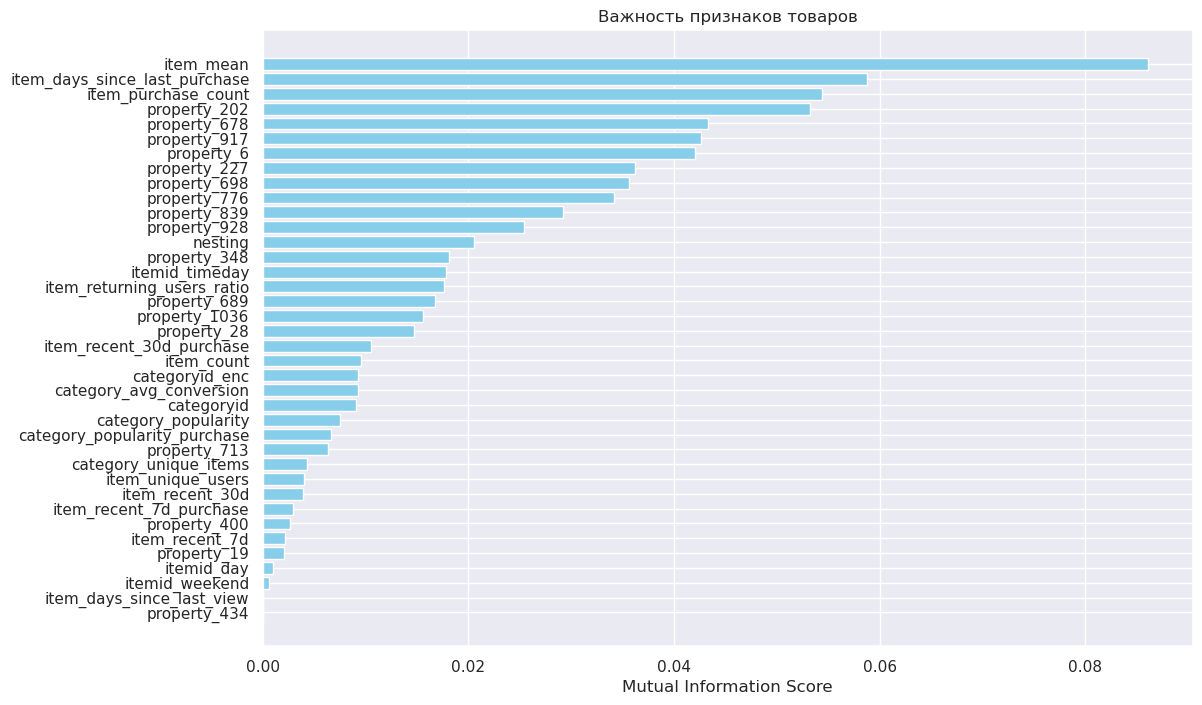

In [65]:
plt.figure(figsize=(12, 8))
plt.barh(mi_df['feature'], mi_df['mi_score'], color='skyblue')
plt.xlabel('Mutual Information Score')
plt.title('Важность признаков товаров')
plt.gca().invert_yaxis()  #самые важные признаки сверху
plt.show()

In [66]:
#стандартизация признаков
scaler_features = ['item_count', 'item_purchase_count', 'item_days_since_last_view',
                   'category_popularity', 'category_unique_items', 'item_unique_users',
                   'item_recent_7d_purchase','item_recent_30d_purchase','item_recent_7d',
                   'category_popularity_purchase','item_days_since_last_purchase','item_recent_30d'
]
for i in scaler_features:
    traindf[i]= StandardScaler().fit_transform(traindf[[i]])

### Признаки для пользователя

In [67]:
traindf.columns

Index(['visitorid', 'property_928', 'itemid', 'property_28', 'timeday',
       'month', 'property_678', 'property_839', 'property_698', 'date',
       'property_689', 'property_434', 'property_917', 'day', 'minute',
       'event', 'property_227', 'property_400', 'property_713', 'property_19',
       'dayofweek', 'weekend', 'timestamp', 'property_776', 'property_348',
       'property_1036', 'target', 'property_202', 'property_6', 'categoryid',
       'nesting', 'categoryid_enc', 'itemid_day', 'itemid_weekend',
       'itemid_timeday', 'item_count', 'item_purchase_count', 'item_mean',
       'item_days_since_last_view', 'category_popularity',
       'category_popularity_purchase', 'category_avg_conversion',
       'category_unique_items', 'item_unique_users',
       'item_returning_users_ratio', 'item_recent_7d',
       'item_recent_7d_purchase', 'item_recent_30d',
       'item_recent_30d_purchase', 'item_days_since_last_purchase'],
      dtype='object')

In [68]:
traindf = value_top(traindf, 'day', 'visitorid')
traindf = value_top(traindf, 'weekend', 'visitorid')
traindf = value_top(traindf, 'timeday', 'visitorid')
traindf = value_top(traindf, 'categoryid', 'visitorid')
#любимая категоия пользователя
cat_dict = dict(zip(traindf['categoryid'], traindf['categoryid_enc']))
traindf['visitorid_categoryid_enc'] = traindf['visitorid_categoryid'].map(cat_dict)

In [69]:
traindf['user_count'] = traindf.groupby('visitorid')['target'].transform('count') #количество пользователя в таблице
traindf['user_purchase_count'] = traindf.groupby('visitorid')['target'].transform('sum') #количество покупок пользователя
traindf['user_mean'] = traindf.groupby('visitorid')['target'].transform('mean') #средняя конверсия для пользователя
#время между действиями
traindf['user_avg_time_between_actions'] = traindf.groupby('visitorid')['timestamp'].transform(lambda x: x.diff().mean())
#возвращение к товарам
traindf['user_repeat_view_ratio'] = traindf.groupby('visitorid')['itemid'].transform(lambda x: x.duplicated().mean())
#изменение активности(последние 7 дней по сравнению с полной историей)
user_7 = (traindf[(traindf.target==1)&(traindf['timestamp'] > (traindf.timestamp.max() - (86400*7)))].groupby('visitorid')['itemid'].count()).rename('user_activity_trend')
traindf = pd.merge(traindf, user_7, on='visitorid', how='left')
traindf['user_activity_trend'] = traindf['user_activity_trend']/traindf.groupby('visitorid')['itemid'].transform('count')

In [70]:
#незаполненные значения
traindf.isnull().sum().sort_values(ascending=False).head(10)

user_activity_trend              210573
user_avg_time_between_actions       245
item_recent_7d                        0
itemid_weekend                        0
itemid_timeday                        0
item_count                            0
item_purchase_count                   0
item_mean                             0
item_days_since_last_view             0
category_popularity                   0
dtype: int64

In [71]:
#активность заполнить 0, время  между действиями большим числом
traindf.fillna({'user_activity_trend': 0,'user_avg_time_between_actions': 120
}, inplace=True)

In [72]:
traindf.columns

Index(['visitorid', 'property_928', 'itemid', 'property_28', 'timeday',
       'month', 'property_678', 'property_839', 'property_698', 'date',
       'property_689', 'property_434', 'property_917', 'day', 'minute',
       'event', 'property_227', 'property_400', 'property_713', 'property_19',
       'dayofweek', 'weekend', 'timestamp', 'property_776', 'property_348',
       'property_1036', 'target', 'property_202', 'property_6', 'categoryid',
       'nesting', 'categoryid_enc', 'itemid_day', 'itemid_weekend',
       'itemid_timeday', 'item_count', 'item_purchase_count', 'item_mean',
       'item_days_since_last_view', 'category_popularity',
       'category_popularity_purchase', 'category_avg_conversion',
       'category_unique_items', 'item_unique_users',
       'item_returning_users_ratio', 'item_recent_7d',
       'item_recent_7d_purchase', 'item_recent_30d',
       'item_recent_30d_purchase', 'item_days_since_last_purchase',
       'visitorid_day', 'visitorid_weekend', 'visitori

In [73]:
user_features = ['visitorid_day', 'visitorid_weekend', 'visitorid_timeday',
                 'visitorid_categoryid', 'visitorid_categoryid_enc', 'user_count',
                 'user_purchase_count', 'user_mean', 'user_avg_time_between_actions',
                 'user_repeat_view_ratio', 'user_activity_trend'
]

In [74]:
#важность признаков
mi_scores = mutual_info_classif(traindf[user_features], traindf['target'], random_state=19)
mi_df = pd.DataFrame({'feature': user_features, 'mi_score': mi_scores}) \
         .sort_values('mi_score', ascending=False) \
         .reset_index(drop=True)

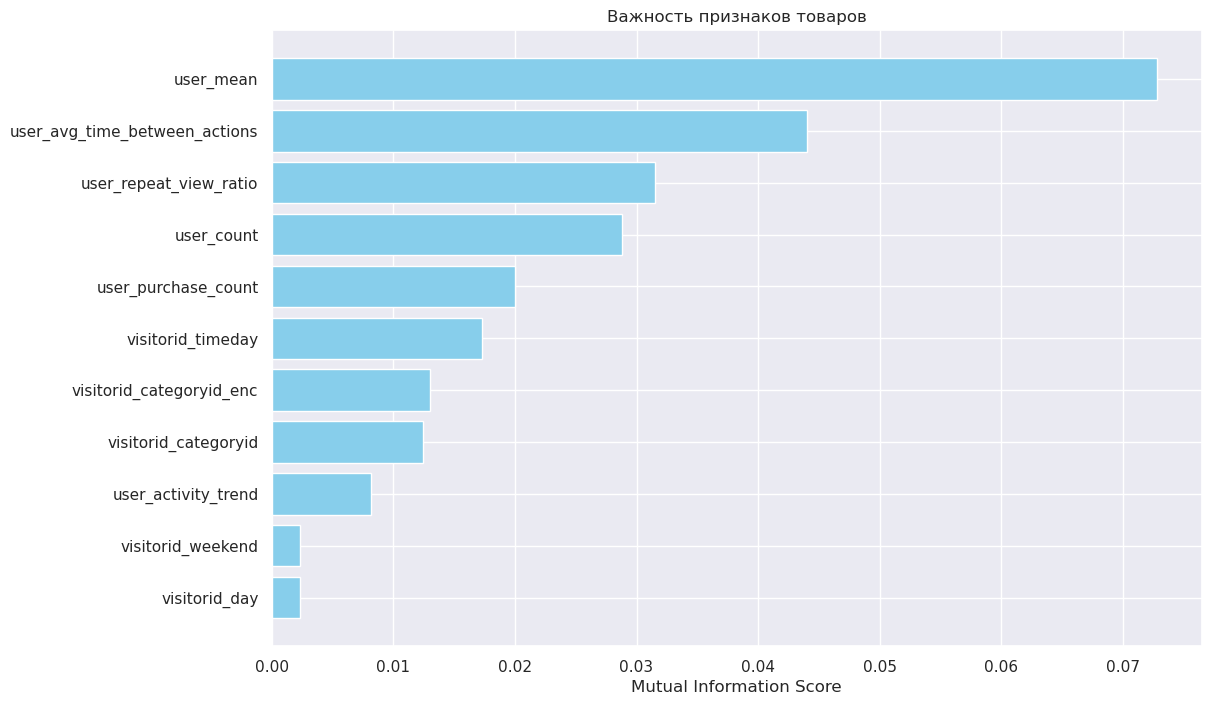

In [75]:
plt.figure(figsize=(12, 8))
plt.barh(mi_df['feature'], mi_df['mi_score'], color='skyblue')
plt.xlabel('Mutual Information Score')
plt.title('Важность признаков товаров')
plt.gca().invert_yaxis()  #самые важные признаки сверху
plt.show()

In [76]:
#стандартизация
scaler_features = ['user_count', 'user_purchase_count', 'user_avg_time_between_actions']
for i in scaler_features:
    traindf[i]= StandardScaler().fit_transform(traindf[[i]])

### Статистические тесты

#### Зависимость вложенности и целевой переменной
* Нулевая гипотеза: признаки Вложенность и Целевая переменная независимы.
* Альтернативная гипотеза: признаки Вложенность и Целевая переменная взаимосвязаны.

In [77]:
alpha = 0.05
table = pd.crosstab(traindf['nesting'], traindf['target'])
_, p, _, _ = stats.chi2_contingency(table)
print(f'p-value = {p}')
#интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-value = 2.1270849102203072e-08
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


#### Зависимость наличия у товара свойства 678 и целевой переменной
* Нулевая гипотеза: признаки свойство 678 и целевая переменная независимы.
* Альтернативная гипотеза: признаки свойство 678 и целевая переменная взаимосвязаны.

In [78]:
alpha = 0.05
table = pd.crosstab(traindf['property_678'], traindf['target'])
_, p, _, _ = stats.chi2_contingency(table)
print(f'p-value = {p}')
#интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-value = 1.0
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


#### Зависимость наличия у товара свойства 1036 и целевой переменной
* Нулевая гипотеза: признаки свойство 1036 и целевая переменная независимы.
* Альтернативная гипотеза: признаки свойство 1036 и целевая переменная взаимосвязаны.

In [79]:
alpha = 0.05
table = pd.crosstab(traindf['property_1036'], traindf['target'])
_, p, _, _ = stats.chi2_contingency(table)
print(f'p-value = {p}')
#интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-value = 0.0668452044668831
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


#### Зависимость самой просматриваемой пользователем категории и целевой переменной
* Нулевая гипотеза: признаки самая просматриваемая категория и целевая переменная независимы.
* Альтернативная гипотеза: признаки самая просматриваемая категория и целевая переменная взаимосвязаны.

In [80]:
alpha = 0.05
table = pd.crosstab(traindf['visitorid_categoryid'], traindf['target'])
_, p, _, _ = stats.chi2_contingency(table)
print(f'p-value = {p}')
#интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-value = 0.0
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


#### Зависимость категории товара и целевой переменной
* Нулевая гипотеза: признаки категория товара и целевая переменная независимы.
* Альтернативная гипотеза: признаки категория товара и целевая переменная взаимосвязаны.

In [81]:
alpha = 0.05
table = pd.crosstab(traindf['categoryid'], traindf['target'])
_, p, _, _ = stats.chi2_contingency(table)
print(f'p-value = {p}')
#интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-value = 0.0
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


# Построение моделей

In [82]:
item_features = ['property_6', 'property_928', 'property_227', 'property_202',
                 'property_689', 'property_713', 'property_678', 'property_348',
                 'property_839', 'property_917', 'property_1036', 'property_19',
                 'property_28', 'property_776', 'property_434', 'property_698',
                 'property_400', 'categoryid', 'nesting', 'categoryid_enc',
                 'itemid_day', 'itemid_weekend', 'itemid_timeday', 'item_count',
                 'item_purchase_count', 'item_mean', 'item_days_since_last_view', 'category_popularity',
                 'category_popularity_purchase', 'category_avg_conversion', 'category_unique_items',
                 'item_unique_users', 'item_returning_users_ratio', 'item_recent_7d',
                 'item_recent_7d_purchase', 'item_recent_30d', 'item_recent_30d_purchase',
                 'item_days_since_last_purchase'
]

user_features = ['visitorid_day', 'visitorid_weekend', 'visitorid_timeday',
                 'visitorid_categoryid', 'visitorid_categoryid_enc', 'user_count',
                 'user_purchase_count', 'user_mean', 'user_avg_time_between_actions',
                 'user_repeat_view_ratio', 'user_activity_trend'
]
features = user_features + item_features

In [83]:
col = ['itemid', 'target', 'minute', 'event', 'date',
       'timestamp', 'timeday', 'dayofweek', 'weekend', 'day',
       'month', 'visitorid'
]
testdf = pd.merge(testdf[col], traindf[['itemid'] + item_features].drop_duplicates(), on='itemid', how='inner')
testdf = pd.merge(testdf, traindf[['visitorid'] + user_features].drop_duplicates(), on='visitorid', how='inner')
train = traindf[['itemid', 'visitorid', 'target', 'timestamp'] + features]
test = testdf[['itemid', 'visitorid', 'target', 'timestamp'] + features]
test_temp = testdf.groupby('visitorid')['target'].sum() #количество покупок пользователя
test = testdf[testdf['visitorid'].isin(test_temp[test_temp>0].index)] #только покупки

### Предварительное исследование целевой переменной

#### Исследуем пользователей, которые были раньше и совершили хотя бы одну покупку в тестовом периоде

In [84]:
test_temp = test
#добавление столбца с индикатором есть ли этот товар в трейне у пользователя
test_temp = pd.merge(test_temp,
                     train[['visitorid', 'itemid']].drop_duplicates(),
                     on=['visitorid', 'itemid'],
                     how='left',
                     indicator=True
)
test_temp['_merge'] = test_temp['_merge'].map({'left_only':'only_test', 'both':'train'})
test_temp.rename(columns={'_merge': 'item_in'}, inplace=True)

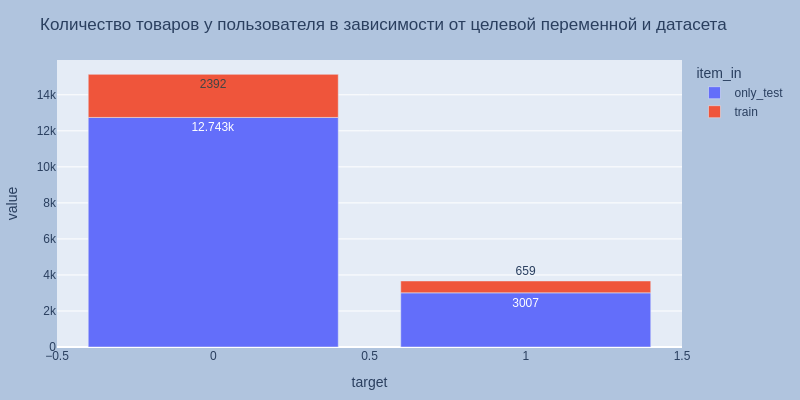

In [85]:
pivot = test_temp.pivot_table(index='target', columns='item_in', values='visitorid', aggfunc='count')
fig = px.bar(pivot, height=400, width=800, text_auto=True,
             title='Количество товаров у пользователя в зависимости от целевой переменной и датасета'
)

fig.update_layout(
    margin=dict(l=20, r=20, t=60, b=20),
    paper_bgcolor='LightSteelBlue',
    showlegend=True
)

fig.show('png')

In [86]:
#доля купленных товаров из теста, которые были в трейне куплены или просмотрены одним и тем же пользователей
train_temp = train.groupby('visitorid')['itemid'].unique()
temp = test_temp[test_temp['target']==1].groupby('visitorid')['itemid'].unique()
temp  = pd.concat([train_temp, temp], join='inner', axis=1)
temp.columns = ['train', 'test']


test_in_train = []
for i in temp.index:
    flags = np.isin(temp.loc[i, 'test'], temp.loc[i, 'train'])
    part = flags.sum()/len(flags)
    test_in_train.append(part)
print(f'В среднем {round(np.array(test_in_train).mean()*100)}% купленных товаров есть у пользователей среди ранее просмотренных')

В среднем 21% купленных товаров есть у пользователей среди ранее просмотренных


In [87]:
#доля купленных товаров из теста, также купленных в трейне одним и тем же пользователей
train_temp = train[train['target']==1].groupby('visitorid')['itemid'].unique()
temp = test_temp[test_temp['target']==1].groupby('visitorid')['itemid'].unique()
temp  = pd.concat([train_temp, temp], join='inner', axis=1)
temp.columns = ['train', 'test']


test_in_train = []
for i in temp.index:
    flags = np.isin(temp.loc[i, 'test'], temp.loc[i, 'train'])
    part = flags.sum()/len(flags)
    test_in_train.append(part)
print(f'В среднем {round(np.array(test_in_train).mean()*100)}% купленных товаров среди ранее купленных')

В среднем 20% купленных товаров среди ранее купленных


In [88]:
#первые 10 пользователей
first10 = test_temp['visitorid'].unique()[:10]
pivot = test_temp[test_temp['visitorid'].isin(first10)].pivot_table(index=['target', 'item_in'], columns='visitorid', values='itemid', aggfunc='count').fillna(0)
pivot

visitorid         5038     518659   548772   652361   825321   861299   \
target item_in                                                           
0      only_test      0.0    390.0     67.0      0.0    116.0    661.0   
       train          1.0     48.0     18.0      2.0     24.0    122.0   
1      only_test      0.0     50.0      5.0      0.0      0.0    175.0   
       train          1.0      8.0      0.0      2.0      1.0      8.0   

visitorid         895999   896088   1150086  1385073  
target item_in                                        
0      only_test    620.0      3.0   1310.0    162.0  
       train         78.0      5.0    312.0     10.0  
1      only_test     53.0      0.0    321.0    106.0  
       train          5.0      2.0     69.0      6.0

Фильтровать рекомендации на наличие уже просмотренных товаров мы не будем - 17% немаленькая цифра, значит есть смысл включить просмотренные товары в рекомендации.

In [89]:
print('Общая доля покупок: ', test[test.target>0].shape[0]/test.shape[0])

Общая доля покупок:  0.19498962821126536


In [90]:
#столбец принадлежности товара к любимой категории пользователя
test_temp['category_in'] = test_temp.apply(lambda x: 1 if x['categoryid']==x['visitorid_categoryid']
                                           else 0, axis=1)

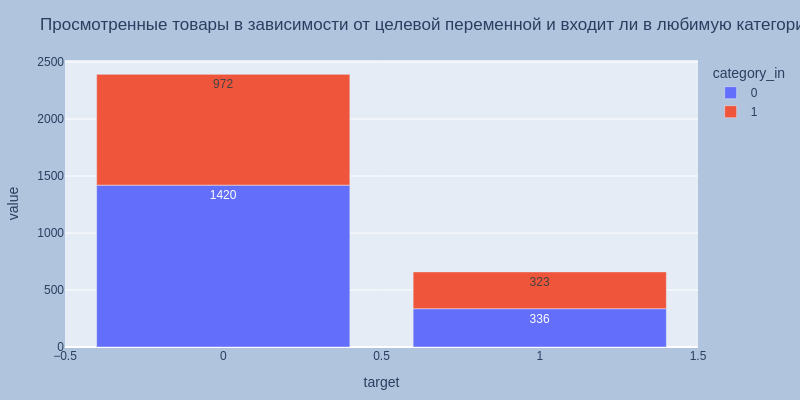

In [91]:
#просмотренные товары(которые есть в трейне у пользователя)
pivot = test_temp[test_temp['item_in']=='train'].pivot_table(index='target', columns='category_in', values='itemid', aggfunc='count')
fig = px.bar(pivot, height=400, width=800, text_auto=True,
    title='Просмотренные товары в зависимости от целевой переменной и входит ли в любимую категорию'
)

fig.update_layout(
    margin=dict(l=20, r=20, t=60, b=20),
    paper_bgcolor='LightSteelBlue',
    showlegend=True
)

fig.show('png')

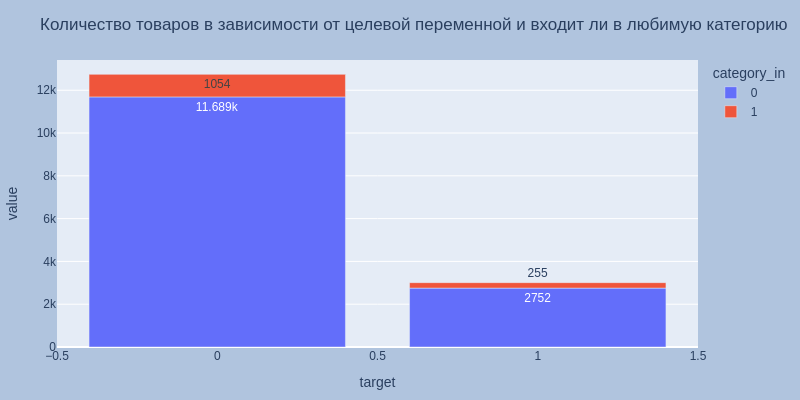

In [92]:
#непросмотренные товары
pivot = test_temp[test_temp['item_in']=='only_test'].pivot_table(index='target', columns='category_in', values='visitorid', aggfunc='count')
fig = px.bar(pivot, height=400, width=800, text_auto=True,
    title='Количество товаров в зависимости от целевой переменной и входит ли в любимую категорию'
)

fig.update_layout(
    margin=dict(l=20, r=20, t=60, b=20),
    paper_bgcolor='LightSteelBlue',
    showlegend=True
)

fig.show('png')

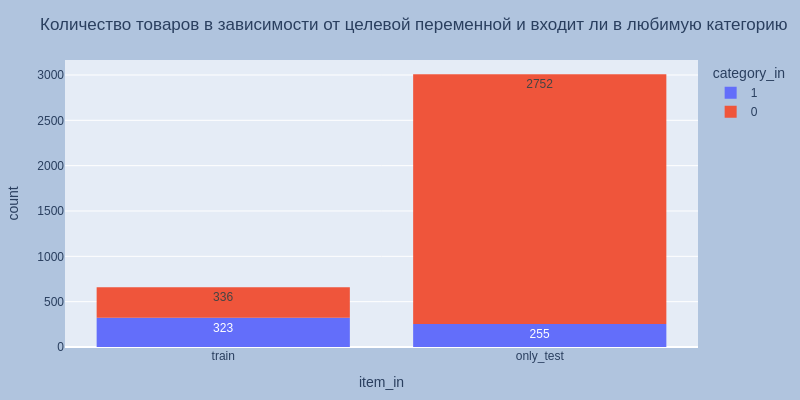

In [93]:
#покупки
pivot = test_temp[test_temp['target']==1].pivot_table(index='target', columns='category_in', values='itemid', aggfunc='count')
fig = px.histogram(test_temp[test_temp['target']==1],x='item_in', height=400, width=800, text_auto=True, color='category_in', histfunc='count',
    title='Количество товаров в зависимости от целевой переменной и входит ли в любимую категорию'
)

fig.update_layout(
    margin=dict(l=20, r=20, t=60, b=20),
    paper_bgcolor='LightSteelBlue',
    showlegend=True
)

fig.show('png')

In [94]:
num = test_temp[test_temp['target']==1].groupby('visitorid')['category_in'].mean().mean()*100
print(f'В среднем {round(num)}% из купленных товаров у каждого пользователя из любимой категории')

В среднем 26% из купленных товаров у каждого пользователя из любимой категории


In [95]:
#из какой категории наибольшее количество пользователей совершает покупки
pairs_cat_vis = train[train['target']==1][['categoryid', 'visitorid']].drop_duplicates()
top_cat = pairs_cat_vis.groupby('categoryid')['visitorid'].count().sort_values().tail(3).index.tolist()
top_cat

[683, 959, 1051]

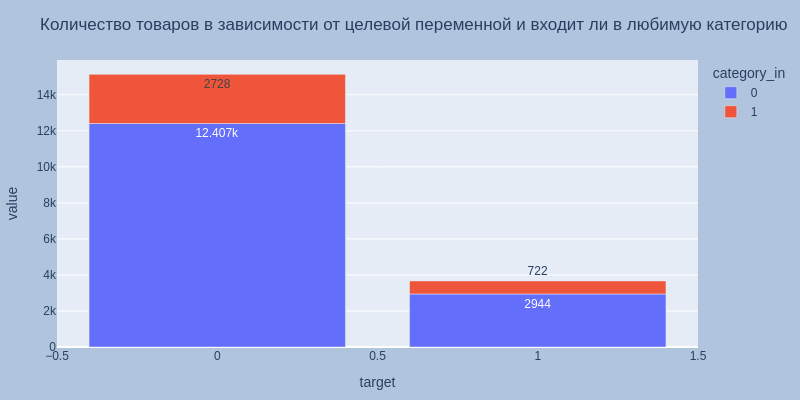

In [96]:
#товары из любимой категории и из топ-3 категорий
test_temp['category_in'] = test_temp.apply(lambda x: 1 if (x['categoryid']==x['visitorid_categoryid'])|(x['categoryid'] in top_cat)
                                           else 0, axis=1)

pivot = test_temp.pivot_table(index='target', columns='category_in', values='itemid', aggfunc='count')
fig = px.bar(pivot, height=400, width=800, text_auto=True,
    title='Количество товаров в зависимости от целевой переменной и входит ли в любимую категорию'
)

fig.update_layout(
    margin=dict(l=20, r=20, t=60, b=20),
    paper_bgcolor='LightSteelBlue',
    showlegend=True
)

fig.show('png')

#### Исследуем новых пользователей, которые совершили хотя бы одну покупку в тестовом периоде

In [97]:
test_temp = testdf[~testdf['visitorid'].isin(traindf['visitorid'].unique())][['visitorid', 'itemid', 'target', 'categoryid']]
temp = test_temp.groupby('visitorid')['target'].sum() #количество покупок пользователя
test_temp = test_temp[test_temp['visitorid'].isin(temp[temp>0].index)]

In [98]:
#самые покупаемые
top_items = train.groupby('itemid')['target'].count().sort_values(ascending=False).head(100).index.tolist()
test_temp['top'] = test_temp['itemid'].apply(lambda x: 1 if x in top_items else 0)
test_temp[test_temp.target==1].top.value_counts()

Series([], Name: count, dtype: int64)

Среди всех купленных товаров новых пользователей только 1 входит в топ-100 самых просматриваемых(в 100 самых покупаемых ни одного).

In [99]:
cat = train.groupby('categoryid')['target'].sum().sort_values(ascending=False).head(3).index.tolist()
test_temp['cat'] = test_temp['categoryid'].apply(lambda x: 1 if x in cat else 0)
test_temp[test_temp.target==1].cat.value_counts()

Series([], Name: count, dtype: int64)

In [100]:
(test_temp[test_temp.target==1].groupby('visitorid')['cat'].sum()/3).mean()*100

nan

В среднем 7% купленных товаров у новых пользователей входят в топ-3 категорий

Думаю неправильно включать этих пользователей в тестовую выборку для расчета метрики, потому что по ним нет никакой информации из-за того что пользователи новые, и никакой взаимосвязи в их покупках в отрыве от хотя бы просмотров нет.

### Коллаборативная фильтрация

In [ ]:
#подсчет пользователей из тестовой таблицы, которых нет в обучающей
#test_users = test.visitorid.nunique()
#new_test_users = len(set(test['visitorid']) - set(train['visitorid']))

#print('В тестовом дата сете {} юзеров'.format(test_users))
#print('В тестовом дата сете {} новых юзеров'.format(new_test_users))

In [102]:
traincol = train.copy()
traincol['target'] = traincol['target'].map({0:20, 1:100})
train_group = traincol.groupby(['visitorid', 'itemid'])['target'].max().reset_index()
train_matrix = coo_matrix((train_group['target'], (train_group['visitorid'], train_group['itemid']))).tocsr()

In [103]:
#купленные или добавленные в корзину товары
result = test[test.target>0].groupby('visitorid')['itemid'].unique()

In [104]:
als = AlternatingLeastSquares(factors=200, 
                                regularization=0.01,
                                iterations=15,
                                random_state=19,
                                calculate_training_loss=True,
                                num_threads=4
                                )
 
als.fit(train_matrix, show_progress=True)

/home/alena/anaconda3/lib/python3.12/site-packages/implicit/cpu/als.py:95: RuntimeWarning:

Intel MKL BLAS is configured to use 10 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'MKL_NUM_THREADS=1' or by callng 'threadpoolctl.threadpool_limits(1, "blas")'. Having MKL use a threadpool can lead to severe performance issues



  0%|          | 0/15 [00:00<?, ?it/s]

In [105]:
#предсказания по id пользователя
recs = als.recommend(userid=range(train_matrix.shape[0]),  
                        user_items=train_matrix,  
                        N=3, 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=False)

In [106]:
def rec(uid, k):
    return als.recommend(userid=uid,  
                        user_items=train_matrix,  
                        N=k, 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=False)

In [107]:
def precision_at_3(k):
    precision = []
    for i in test['visitorid'].unique():
        pred = rec(i, k)
        y = test[(test['target']==1)&(test['visitorid']==i)]['itemid'].unique().tolist()

        flags = np.isin(pred, y)
        if len(y)<k:
            p = flags.sum() / len(y)
        else:
            p = flags.sum() / k
        precision.append(p)
    return np.array(precision).mean()

In [108]:
precision_at_3(3)

0.13984220907297829

### Кандидатогенератор

In [109]:
#кодировщики для пользователей и товаров
user_encoder = LabelEncoder().fit(train['visitorid'])
item_encoder = LabelEncoder().fit(train['itemid'])
#уникальные
unique_users = train['visitorid'].unique()
unique_items = train['itemid'].unique()

In [110]:
def recommend(uid, model, k=20):
    '''Получение рекомендаций из модели ALS'''
    if uid not in unique_users:
        return []
    uidx = user_encoder.transform([uid])[0]
    items = model.recommend(uidx, 
                            user_items=None, 
                            N=k, 
                            filter_already_liked_items=False)
    result = []
    for i in items[0]:
        result.append(item_encoder.inverse_transform([i])[0])
    return result
def recall_als(model, k):
    '''Расчет полноты рекомендаций для ALS'''
    recall = []
    for i in test['visitorid'].unique():
        pred = recommend(i, model, k)
        y = test[(test['target']==1)&(test['visitorid']==i)]['itemid'].unique().tolist()
        flags = np.isin(y, pred)
        if len(y)>len(pred):
            p = flags.sum() / len(pred)
        else:
            p = flags.sum() / len(y)
        recall.append(p)
    return np.array(recall).mean()

In [111]:
#значения для сводной таблицы
rows = user_encoder.transform(train['visitorid'])
cols = item_encoder.transform(train['itemid'])
values = train['target'].apply(lambda x: 1000.0 if x == 1 else 100).values #изменение таргета
user_item_matrix = csr_matrix((values, (rows, cols)), shape=(len(unique_users), len(unique_items))).tocsr()

In [112]:
#функция для оптимизации
def objective(trial):
    params = {'factors': trial.suggest_int('factors', 32, 256),
            'regularization': trial.suggest_float('regularization', 0.01, 0.2),
            'alpha': trial.suggest_float('alpha', 10, 100),
            'iterations': trial.suggest_int('iterations', 10, 50)
    }
    model = AlternatingLeastSquares(
            **params,
            calculate_training_loss=True,
            num_threads=4,
            random_state=19
    )
    model.fit(user_item_matrix, show_progress=False)
    return recall_als(model, 20)
#оптимизация гиперпараметров
study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=19))
study.optimize(objective, n_trials=50)
#лучшие параметры
best_params_als = study.best_params
print(f"Best recall: {study.best_value}")
print("Best params:", best_params_als)
best_als = AlternatingLeastSquares(**best_params_als, random_state=19)
best_als.fit(user_item_matrix)

[I 2025-06-02 12:11:27,805] A new study created in memory with name: no-name-2041b848-8edb-47c3-9bf6-3d85fd1f2cfb
[I 2025-06-02 12:11:34,075] Trial 0 finished with value: 0.20990553496470654 and parameters: {'factors': 53, 'regularization': 0.1546374461682227, 'alpha': 32.22441758496943, 'iterations': 15}. Best is trial 0 with value: 0.20990553496470654.
[I 2025-06-02 12:11:41,828] Trial 1 finished with value: 0.2210254965284551 and parameters: {'factors': 106, 'regularization': 0.025769917351309644, 'alpha': 70.477937315242, 'iterations': 43}. Best is trial 1 with value: 0.2210254965284551.
[I 2025-06-02 12:11:53,174] Trial 2 finished with value: 0.2217004067595784 and parameters: {'factors': 253, 'regularization': 0.130775539611402, 'alpha': 29.433093044246228, 'iterations': 32}. Best is trial 2 with value: 0.2217004067595784.
[I 2025-06-02 12:12:01,414] Trial 3 finished with value: 0.22934466913756857 and parameters: {'factors': 154, 'regularization': 0.05447445389793031, 'alpha': 2

Best recall: 0.23637395149229465
Best params: {'factors': 148, 'regularization': 0.02205850352887652, 'alpha': 13.526664255279133, 'iterations': 40}


  0%|          | 0/40 [00:00<?, ?it/s]

In [140]:
def generate_candidates(df, als_model, uid, k):
    '''Генерация кандидатов для пользователя'''
    mask_time = df['timestamp'] > (df.timestamp.max() - (86400*7))
    candidates = []
    items = []
    candidates.extend(recommend(uid, als_model, k))
    items.extend(df[mask_time]['itemid'].values)
    items = list(set(items))
    uvec = als_model.user_factors[user_encoder.transform([uid])[0]]
    ivec = als_model.item_factors[item_encoder.transform(items)]
    scores = dict(zip(items, np.dot(ivec, uvec.T)))
    scores = sorted(scores.items(), key=lambda item: -item[1])
    scores = {k: v for k, v in scores}
    candidates.extend(list(scores.keys())[:k])
    return candidates

def recall_canditates(n):
    '''Полнота рекомендаций для кандидатогенератора'''
    recall = []
    for i in test['visitorid'].unique():
        pred = generate_candidates(train, best_als, i, n)
        y = test[(test['visitorid']==i)&(test.target==1)]['itemid'].values.tolist()
        
        flags = np.isin(y, pred)
        if len(y)>len(pred):
            p = flags.sum() / len(pred)
        else:
            p = flags.sum() / len(y)
        recall.append(p)
    return np.array(recall).mean()

In [114]:
recall_canditates(10)

0.22199722340401443

### LightGBM

In [ ]:
def prepare_reranker_data(df, als_model):
    '''Датасет для обучения реранкера'''
    user_factors = als_model.user_factors
    item_factors = als_model.item_factors
    #кодирование фичей
    data = []
    for uidx in range(user_factors.shape[0]):
        uid = user_encoder.inverse_transform([uidx])[0]
        #кандидаты из ALS
        candidate_indices = generate_candidates(df, als_model, uid, 20)
        #фичи пользователя
        user_feats = df[df['visitorid'] == uid][user_features].values[0]
        #для каждого кандитата
        for iid in candidate_indices:
            iidx = item_encoder.transform([iid])[0]
            #фичи товара
            item_feats = df[df['itemid'] == iid][item_features].values[0]
            #целевая переменная: 1 если было взаимодействие, иначе 0
            target = 1 if user_item_matrix[uidx, iidx] > 0 else 0
            #все фичи
            features = np.concatenate([(user_factors[uidx]), (item_factors[iidx]),
            user_feats, item_feats                             
            ])
            data.append((uidx, features, target))
    #массивы
    users = np.array([x[0] for x in data])
    X = np.vstack([x[1] for x in data])
    y = np.array([x[2] for x in data])
    return X, y, users

def recommend_rr(df, uid, als_model, reranker, k, n):
	'''Рекомендации для пользователя'''
	candidate_indices = generate_candidates(df, als_model, uid, n)
	uidx = user_encoder.transform([uid])[0]
	user_vec = als_model.user_factors[uidx]
	user_feats = df[df['visitorid'] == uid][user_features].values[0]
	candidates = []
	for iid in candidate_indices:
		iidx = item_encoder.transform([iid])[0]
		item_feats = df[df['itemid'] == iid][item_features].values[0]
		features = np.concatenate([user_vec, als_model.item_factors[iidx], user_feats, item_feats])
		candidates.append((iid, features))
	X_rerank = np.vstack([x[1] for x in candidates])
	scores = reranker.predict(X_rerank)
	sorted_indices = np.argsort(-scores)
	recommendations = [candidates[i][0] for i in sorted_indices[:k]]
	return recommendations

def precision_rr(als_model, model, k, n):
    '''Precision@k после ранжирования'''
    precision = []
    for i in test['visitorid'].unique():
        pred = recommend_rr(train, i, als_model, model, k, n)
        y = test[(test['target']==1)&(test['visitorid']==i)]['itemid'].unique().tolist()
        flags = np.isin(pred, y)
        if len(y)<k:
            p = flags.sum() / len(y)
        else:
            p = flags.sum() / k
        precision.append(p)
    return np.array(precision).mean()

In [116]:
X, y, users = prepare_reranker_data(train, best_als)

In [117]:
def objective(trial):
    params = {
        'objective': 'lambdarank',
        'metric': 'ndcg',
        'boosting_type': 'gbdt',
        'importance_type': 'gain',
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 10, 100),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 200, 400),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-9, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-9, 10.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'lambdarank_truncation_level': trial.suggest_int('lambdarank_truncation_level', 3, 10),
        'verbosity': -1
    }
    model = LGBMRanker(**params, lambarank_norm=True, random_state=19)
    model.fit(X, y, group=np.bincount(users))
    return precision_rr(best_als, model, k=3, n=5)
study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=19))
study.optimize(objective, n_trials=50)
best_params_rr = study.best_params

[I 2025-06-02 12:28:17,341] A new study created in memory with name: no-name-2e3bbabd-41f8-4bd0-8b26-f9c656f566c9
[I 2025-06-02 12:28:47,124] Trial 0 finished with value: 0.12071005917159763 and parameters: {'scale_pos_weight': 18.778024157450645, 'num_leaves': 81, 'learning_rate': 0.023161001183405354, 'n_estimators': 227, 'min_child_samples': 36, 'max_depth': 3, 'reg_alpha': 0.005245305803365814, 'reg_lambda': 0.11639598010499581, 'subsample': 0.991370957272107, 'colsample_bytree': 0.8178303673984263, 'lambdarank_truncation_level': 4}. Best is trial 0 with value: 0.12071005917159763.
[I 2025-06-02 12:29:17,178] Trial 1 finished with value: 0.1282051282051282 and parameters: {'scale_pos_weight': 59.41246888758516, 'num_leaves': 64, 'learning_rate': 0.022169645204427414, 'n_estimators': 222, 'min_child_samples': 52, 'max_depth': 4, 'reg_alpha': 0.00021225640563023423, 'reg_lambda': 7.4142578294287195e-06, 'subsample': 0.8441636917110822, 'colsample_bytree': 0.6864635782041965, 'lambdar

In [118]:
model_rr = LGBMRanker(**best_params_rr, lambarank_norm=True,random_state=19)
model_rr.fit(X, y, group=np.bincount(users))
precision_rr(best_als, model_rr, 3, 5)

0.2522682445759369

In [119]:
importance = model_rr.booster_.feature_importance(importance_type='gain')[296:]
feature_names = features
importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
}).sort_values('importance', ascending=False)
print(importance_df.head(5))

                   feature    importance
44          item_recent_7d  25595.587815
42       item_unique_users  23148.978965
5               user_count  11956.392976
9   user_repeat_view_ratio  11336.117312
10     user_activity_trend   8878.923830


### дальше

In [120]:
def change_train(traindf, scaler=False):
    '''Добавление новых признаков к датафрейму'''
    new_train = traindf.copy()
    new_train = value_top(new_train, 'day', 'itemid')
    new_train = value_top(new_train, 'weekend', 'itemid')
    new_train = value_top(new_train, 'timeday', 'itemid')
    new_train['item_count'] = new_train.groupby('itemid')['target'].transform('count')
    new_train['item_purchase_count'] = new_train.groupby('itemid')['target'].transform('sum').fillna(0)
    new_train['item_mean'] = new_train.groupby('itemid')['target'].transform('mean')
    new_train['item_days_since_last_view'] = round((testdf.timestamp.min() - new_train.groupby('itemid')['timestamp'].transform('max'))/86400)
    new_train['category_popularity'] = new_train.groupby('categoryid')['itemid'].transform('count')
    new_train['category_popularity_purchase'] = new_train.groupby('categoryid')['target'].transform('sum')
    new_train['category_avg_conversion'] = new_train.groupby('categoryid')['target'].transform('mean')
    new_train['category_unique_items'] = new_train.groupby('categoryid')['itemid'].transform('nunique')
    new_train['item_unique_users'] = new_train.groupby('itemid')['visitorid'].transform('nunique')
    new_train['item_returning_users_ratio'] = new_train.groupby('itemid')['visitorid'].transform(lambda x: x.duplicated().mean())
    items7 = new_train[new_train['timestamp'] > (new_train.timestamp.max() - (86400*7))].groupby('itemid')['target'].count().rename('item_recent_7d')
    items7_purchase = new_train[new_train['timestamp'] > (new_train.timestamp.max() - (86400*7))].groupby('itemid')['target'].sum().rename('item_recent_7d_purchase')
    items30 = new_train[new_train['timestamp'] > (new_train.timestamp.max() - (86400*30))].groupby('itemid')['target'].count().rename('item_recent_30d')
    items30_purchase = new_train[new_train['timestamp'] > (new_train.timestamp.max() - (86400*30))].groupby('itemid')['target'].sum().rename('item_recent_30d_purchase')
    days_since_last_purchase = round((testdf.timestamp.min() - new_train[new_train.target==1].groupby('itemid')['timestamp'].max())/86400).rename('item_days_since_last_purchase')
    new_train = pd.merge(new_train, items7, on='itemid', how='left')
    new_train = pd.merge(new_train, items7_purchase, on='itemid', how='left')
    new_train = pd.merge(new_train, items30, on='itemid', how='left')
    new_train = pd.merge(new_train, items30_purchase, on='itemid', how='left')
    new_train = pd.merge(new_train, days_since_last_purchase, on='itemid', how='left')
    
    new_train = value_top(new_train, 'day', 'visitorid')
    new_train = value_top(new_train, 'weekend', 'visitorid')
    new_train = value_top(new_train, 'timeday', 'visitorid')
    new_train = value_top(new_train, 'categoryid', 'visitorid')
    cat_dict = dict(zip(new_train['categoryid'], new_train['categoryid_enc']))
    new_train['visitorid_categoryid_enc'] = new_train['visitorid_categoryid'].map(cat_dict)
    new_train['user_count'] = new_train.groupby('visitorid')['target'].transform('count')
    new_train['user_purchase_count'] = new_train.groupby('visitorid')['target'].transform('sum')
    new_train['user_mean'] = new_train.groupby('visitorid')['target'].transform('mean')
    new_train['user_avg_time_between_actions'] = new_train.groupby('visitorid')['timestamp'].transform(lambda x: x.diff().mean())
    new_train['user_repeat_view_ratio'] = new_train.groupby('visitorid')['itemid'].transform(lambda x: x.duplicated().mean())
    user_7 = (new_train[(new_train.target==1)&(new_train['timestamp'] > (new_train.timestamp.max() - (86400*7)))].groupby('visitorid')['itemid'].count()).rename('user_activity_trend')
    new_train = pd.merge(new_train, user_7, on='visitorid', how='left')
    new_train['user_activity_trend'] = new_train['user_activity_trend']/new_train.groupby('visitorid')['itemid'].transform('count')
    new_train.fillna({'item_recent_7d_purchase': 0,'item_recent_30d_purchase': 0,'item_recent_7d': 0,
                'item_days_since_last_purchase': 120,'item_recent_30d': 0,
                'user_activity_trend': 0,'user_avg_time_between_actions': 120
    }, inplace=True)
    if scaler==True:
        scaler_features = ['item_count', 'item_purchase_count', 'item_days_since_last_view',
                   'category_popularity', 'category_unique_items', 'item_unique_users',
                   'item_recent_7d_purchase','item_recent_30d_purchase','item_recent_7d',
                   'category_popularity_purchase','item_days_since_last_purchase','item_recent_30d',
                   'user_count', 'user_purchase_count', 'user_avg_time_between_actions'
        ]
        for i in scaler_features:
            new_train[i]= StandardScaler().fit_transform(new_train[[i]])
    return new_train

In [121]:
dfmin = change_train(dfmin, scaler=True)
#кодировщики для пользователей и товаров
user_encoder = LabelEncoder().fit(dfmin['visitorid'])
item_encoder = LabelEncoder().fit(dfmin['itemid'])
#уникальные
unique_users = dfmin['visitorid'].unique()
unique_items = dfmin['itemid'].unique()
#значения для сводной таблицы
rows = user_encoder.transform(dfmin['visitorid'])
cols = item_encoder.transform(dfmin['itemid'])
values = dfmin['target'].apply(lambda x: 1000.0 if x == 1 else 100).values #изменение таргета
user_item_matrix = csr_matrix((values, (rows, cols)), shape=(len(unique_users), len(unique_items))).tocsr()
#лучшие параметры
final_als = AlternatingLeastSquares(**best_params_als)
final_als.fit(user_item_matrix)
#сохранение
with open('final_als.pkl', 'wb') as f:
    pickle.dump(final_als, f)
#реранкер
X_f, y_f, users_f = prepare_reranker_data(dfmin, final_als)
final_rr = LGBMRanker(**best_params_rr, lambdarank_norm=True, random_state=19)
final_rr.fit(X_f, y_f, group=np.bincount(users_f))
with open('final_rr.pkl', 'wb') as f:
    pickle.dump(final_rr, f)

  0%|          | 0/40 [00:00<?, ?it/s]

In [ ]:
#dfmin.to_csv('data/data.csv', index=False)

In [122]:
best_params_als

{'factors': 148,
 'regularization': 0.02205850352887652,
 'alpha': 13.526664255279133,
 'iterations': 40}

In [123]:
best_params_rr

{'scale_pos_weight': 32.76646433606382,
 'num_leaves': 68,
 'learning_rate': 0.13252142979294942,
 'n_estimators': 295,
 'min_child_samples': 12,
 'max_depth': 8,
 'reg_alpha': 1.3583072289221058e-09,
 'reg_lambda': 0.04857113119670418,
 'subsample': 0.948178146926568,
 'colsample_bytree': 0.9433960599960594,
 'lambdarank_truncation_level': 9}

В данный момент подбор рекомендаций осуществляется по id пользователя. Это сделано для упрощения визуального отображения и ввода идентификатора. Можно изменить для ввода не идентификатора, а, например, купленных и просмотренных пользователем товаров. Такой способ будет удобен для автоматической подачи данных и позволит подбирать рекомендации пользователям, которых нет в списке.